In [38]:
%load_ext autoreload
%autoreload 2

import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

import os
from importlib import reload

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch

plt.rcParams['axes.facecolor'] = 'white'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import renyi
import utils
reload(renyi)
from renyi import mink_sim_divergence, renyi_mixture_divergence, mink_mixture_divergence, rbf_kernel, generic_kernel

In [40]:
class GeneratorFC(nn.Module):
    def __init__(self, input_size, output_size, hidden_dims):
        super(GeneratorFC, self).__init__()
        self.layers = []

        prev_dim = input_size
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.LeakyReLU())
            prev_dim = hidden_dim
        self.layers.append(nn.Linear(prev_dim, output_size))

        self.layer_module = nn.ModuleList(self.layers)

    def forward(self, x):
        out = x
        for layer in self.layer_module:
            out = layer(out)
        return out

In [41]:
def old_mixture_divergence(mu, X, nu, Y, kernel, alpha):   
    n, m = mu.shape[0], nu.shape[0]
    
    W = torch.cat((X, Y))
    
    # Compute similarity matrix
    K = kernel(W)
    
    v = (K[:n, :n] @ mu) / utils.min_clamp(K[:n, -m:] @ nu)
    v = mu.transpose(-2, -1) @ (v **(alpha-1))
    v = utils.clamp_log(v)
    
    u = (K[-m:, -m:] @ nu) / utils.min_clamp(K[-m:, :n] @ mu)
    u = nu.transpose(-2, -1) @ (u **(alpha-1))
    u = utils.clamp_log(u)
    
    return (u + v) / (alpha - 1)

def old_rbf_kernel(W, sigmas=[1.], p=2):
    pdist = torch.norm(W[..., None, :] - W[..., None, :, :], p=p, dim=-1)
    res = torch.zeros_like(pdist)
    for sigma in sigmas:
        res += torch.exp(- pdist / (2 * sigma**2))
    return res / len(sigmas)

In [42]:
from sklearn.datasets.samples_generator import make_swiss_roll

d, z_dim, gen_hiddens = 2, 16, [128, 128]
batch_size = 32

In [43]:
generator = GeneratorFC(z_dim, d, gen_hiddens)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3, betas=(0.9, 0.999))

gaussian_kernel = lambda x, y: generic_kernel(x, y, lambda u, v: rbf_kernel(u, v, sigmas=[0.2]))
old_kernel = lambda x: old_rbf_kernel(x, sigmas=[0.2])

In [50]:
alpha = 0.1

for _ in range(1000):
    
    g_optimizer.zero_grad()
    
    x_real = torch.Tensor(make_swiss_roll(batch_size, noise=0.1)[0][:, [0, 2]]/10)
    x_real += 0.01 * torch.randn_like(x_real)
    
    z = torch.randn(2 * batch_size, z_dim)
    x_fake = generator(z)
    emp_probs1 = torch.ones(1, batch_size)/batch_size
    emp_probs2 = torch.ones(1, 2*batch_size)/(2*batch_size)
    
    loss = renyi_mixture_divergence(emp_probs1, x_real, emp_probs2, x_fake, gaussian_kernel, alpha)
#     loss = old_mixture_divergence(emp_probs.t(), x_real, emp_probs.t(), x_fake, old_kernel, alpha)

    if _ % 100 == 0:
        print("%d - %.4f" % (_, loss.item()))

    loss.backward()

    g_optimizer.step()

0 - 1.1094
100 - 1.7578
200 - 1.0048
300 - 1.3486
400 - 1.3776
500 - 1.0505
600 - 0.9961
700 - 1.2115
800 - 1.3270
900 - 1.5794


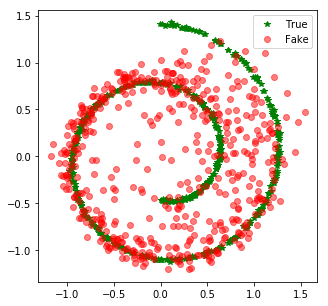

In [51]:
x_real = make_swiss_roll(500, noise=0.1)[0][:, [0, 2]]/10
z = torch.randn(500, z_dim)
x_fake = generator(z).data.numpy()

plt.figure(figsize=(5, 5))
plt.plot(x_real[:, 0], x_real[:, 1], 'g*', label='True')
plt.plot(x_fake[:, 0], x_fake[:, 1], 'ro', alpha=0.5, label='Fake')
plt.legend(loc='best');